In [33]:
%matplotlib inline

In [98]:
import numpy as np
import pandas as pd
import seaborn as sns

In [99]:
features_raw = pd.read_csv('parliament_processed_final.csv')

In [100]:
features_raw = features_raw.drop(['BillNumberOfPages','SponsorParty', 'ParliamentNumber', 'SponsorGender', 'SessionNumber'], axis=1)

In [101]:
features_raw['BillMonthOfYear'] = features_raw['BillMonthOfYear'].astype('category')
features_raw['IsSponsorInPower'] = features_raw['IsSponsorInPower'].astype('category')

In [102]:
features_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 537 entries, 0 to 536
Data columns (total 7 columns):
BillType                537 non-null object
DaysUntilRoyalAssent    537 non-null int64
PrimeMinisterName       537 non-null object
PrimeMinisterParty      537 non-null object
SponsorTitle            535 non-null object
BillMonthOfYear         537 non-null category
IsSponsorInPower        537 non-null category
dtypes: category(2), int64(1), object(4)
memory usage: 22.2+ KB


In [103]:
days_raw = features_raw['DaysUntilRoyalAssent']
features_raw = features_raw.drop('DaysUntilRoyalAssent', axis=1)

In [104]:
features = pd.get_dummies(features_raw)

In [105]:
fast = days_raw < 171

In [106]:
from sklearn.cross_validation import train_test_split

In [107]:
X_train, X_test, y_train, y_test = train_test_split(features, fast, test_size=0.2, random_state=0)

In [108]:
from sklearn.linear_model import LogisticRegression

In [109]:
logr = LogisticRegression()

In [110]:
logr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [111]:
preds = logr.predict(X_test)

In [117]:
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix

In [118]:
conf_matrix = confusion_matrix(y_test, preds)

In [119]:
accuracy_score(y_test, preds)

0.79629629629629628

In [120]:
roc_auc_score(y_test, preds)

0.7756708407871199

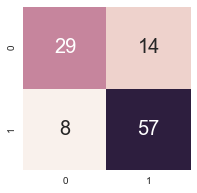

In [121]:
import matplotlib.pyplot as plt
conf_matrix = confusion_matrix(y_test, preds)
plt.rcParams['figure.figsize']=(3,3)
sns.heatmap(conf_matrix, annot=True, fmt='d', annot_kws={"size": 20}, cbar=False);

In [122]:
features_raw[features_raw['SponsorTitle'].isnull()]

,BillType,PrimeMinisterName,PrimeMinisterParty,SponsorTitle,BillMonthOfYear,IsSponsorInPower
463,Senate Public Bill,Paul Martin,Liberal,NaN,10,True
489,Senate Public Bill,Jean Chrétien,Liberal,NaN,2,False


In [185]:
# Final model
bill_dict = ({'BillType': 'House Government Bill', 'PrimeMinisterName': 'Justin Trudeau', 'PrimeMinisterParty': 'Liberal', 'SponsorTitle': 'Minister of Justice', 'BillMonthOfYear': '4', 'IsSponsorInPower': True})
bill_C45 = pd.DataFrame([bill_dict])

In [186]:
bill_C45 = pd.get_dummies(bill_C45)
bill_C45 = features.append(bill_C45).iloc[-1]
bill_C45 = bill_C45.fillna(value=0)

In [187]:
bill_C45 = bill_C45.drop('IsSponsorInPower')

In [193]:
logr.predict_proba(bill_C45)

/Users/zarak/anaconda3/lib/python3.5/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


array([[ 0.83245597,  0.16754403]])

In [192]:
bill_C45['IsSponsorInPower_True'] = 1

## Gridsearch

In [133]:
from sklearn.grid_search import GridSearchCV 
from sklearn.cross_validation import ShuffleSplit
from sklearn.metrics import make_scorer, fbeta_score

def fit_model(X, y):
    cv_sets = ShuffleSplit(X.shape[0], n_iter=5, test_size=0.10, random_state=0)
    # cv_sets = StratifiedShuffleSplit(y, test_size=0.10)
    
    clf = LogisticRegression()
    
    params = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
    
    scorer = make_scorer(roc_auc_score)
    
    grid = GridSearchCV(clf, params, scorer)
    
    grid = grid.fit(X, y)
    
    return grid.best_estimator_

In [134]:
reg = fit_model(X_train, y_train)

In [136]:
preds2 = reg.predict(X_test)

In [137]:
accuracy_score(y_test, preds2)

0.80555555555555558

In [138]:
roc_auc_score(y_test, preds2)

0.78336314847942745

In [139]:
confusion_matrix(y_test, preds2)

array([[29, 14],
       [ 7, 58]])

In [194]:
reg.predict_proba(bill_C45)

/Users/zarak/anaconda3/lib/python3.5/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


array([[ 0.92055055,  0.07944945]])

In [171]:
import matplotlib.pyplot as pl

def feature_plot(importances, X_train, y_train):
    
    # Display the five most important features
    indices = np.argsort(importances)[::-1]
    columns = X_train.columns.values[indices[:5]]
    values = importances[indices][:5]

    # Creat the plot
    fig = pl.figure(figsize = (9,5))
    pl.title("Normalized Weights for First Five Most Predictive Features", fontsize = 16)
    pl.bar(np.arange(5), values, width = 0.6, align="center", color = '#00A000', \
          label = "Feature Weight")
    pl.bar(np.arange(5) - 0.3, np.cumsum(values), width = 0.2, align = "center", color = '#00A0A0', \
          label = "Cumulative Feature Weight")
    pl.xticks(np.arange(5), columns, rotation=10)
    pl.xlim((-0.5, 4.5))
    pl.ylabel("Weight", fontsize = 12)
    pl.xlabel("Feature", fontsize = 12)
    
    pl.legend(loc = 'upper center')
    pl.tight_layout()
    pl.show()

In [172]:
from sklearn.ensemble import GradientBoostingClassifier

In [173]:
gbc = GradientBoostingClassifier()

In [174]:
gbc.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=None,
              subsample=1.0, verbose=0, warm_start=False)

In [175]:
importances = gbc.feature_importances_

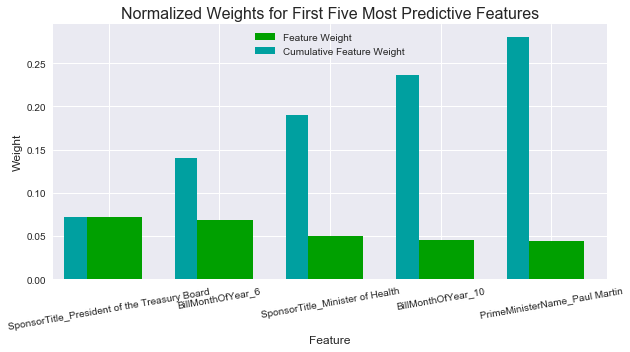

In [176]:
feature_plot(importances, X_train, y_train)